In [1]:
import numpy as np 
import pandas as pd
import os

In [2]:
from keras.layers import LSTM, Bidirectional, Embedding, Input, Flatten, Dense, BatchNormalization, Dropout, Conv1D, Concatenate, MaxPool1D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPool1D, SpatialDropout1D, TimeDistributed, Lambda, Add, Embedding, GRU, CuDNNGRU

Using TensorFlow backend.


In [3]:
from keras.layers import Add

In [4]:
from keras.optimizers import Adam

In [5]:
import keras
import tensorflow as tf
import keras.backend as K
from keras.models import Model

In [6]:
from keras.preprocessing.sequence import pad_sequences

In [7]:
from keras.utils import plot_model

In [8]:
import numpy as np
import math

In [9]:
import joblib
from sklearn.metrics import roc_auc_score

In [38]:
class Attention(keras.layers.Layer):
    def __init__(self, attn_dim, **kwargs):
        self.attn_dim = attn_dim
        super(Attention,self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.kernel_w = self.add_weight(name='Ww',
                                        shape=(input_shape[-1],self.attn_dim),
                                        initializer='uniform',
                                        trainable=True
                                       )
        self.kernel_wb = self.add_weight(name='Wbias', shape=(self.attn_dim,), initializer='zeros',trainable=True)
        self.kernel_uw = self.add_weight(name='uw',
                                        shape=(self.attn_dim,),
                                        initializer='uniform',
                                        trainable=True
                                       )
        super(Attention, self).build( input_shape)
    
    def compute_mask(self, inputs, mask=None):
        return None
    
    def call(self,hit, mask=None):
        print ("shape of hit is {}".format(hit.shape))
        print ("shape of kernel_w is {}".format(self.kernel_w.shape))
        print ("shape of kernel_wb is {}".format(self.kernel_wb.shape))
        print ("shape of kernel_uw is {}".format(self.kernel_uw.shape))
        print ("shape of expanded kernel is {}".format(K.expand_dims(self.kernel_w,0)))
        uit = K.squeeze(K.dot(hit,K.expand_dims(K.transpose(self.kernel_w))),axis=-1)

        print ("UIT shape is {}".format(uit.shape))
        uit = K.tanh(uit + self.kernel_wb)

        print ("shape of uit is {}".format(uit.shape))
        alpha_it_num = K.exp(K.squeeze(K.dot( uit,K.expand_dims(self.kernel_uw)),axis=-1))
        
        
        print ("Shape of alpha_num is {}".format(alpha_it_num.shape))
        if mask is not None:
            alpha_it_num *= K.cast(mask,K.floatx())
            
        print ("Shape of alpha_num after mask multiplication {}".format(alpha_it_num.shape))
        
        alpha_it = alpha_it_num/K.cast((K.sum(alpha_it_num, axis=1, keepdims=True)+K.epsilon()),K.floatx())

        print ("shape of alpha_it is {}".format(alpha_it.shape))
        si = hit*K.expand_dims(alpha_it,2)
        print ("shape of si is {}".format(si.shape))
        si = K.sum(si, axis=1)
#         si = K.cast(K.sum(alpha_it_num, axis=1, keepdims=True),K.floatx())
        print ("shape of si after sum is {}".format(si.shape))
        return si
    
    def compute_output_shape(self,input_shape):
        return(input_shape[0],input_shape[-1])

In [39]:
# embedding = joblib.load('/Users/mayoor/dev/kaggle/tc/embedding')

In [40]:
# tokenizer = joblib.load('/Users/mayoor/dev/kaggle/tc/tokenizer')

In [41]:
maxlen = 200

In [42]:
def get_model(n_classes=1, maxlen=200):
    input = Input(shape=(maxlen,))
    x = Embedding(input_dim=embedding.shape[0], output_dim=embedding.shape[1], input_length=maxlen, weights=[embedding], trainable=False, mask_zero=True)(input)
#     x = SpatialDropout1D(0.3)(x)
    hit = Bidirectional(GRU(128, return_sequences=True))(x)
    attn_vec = Attention(128)(hit)
    output = Dense(128,activation='relu')(attn_vec)
    output = Dropout(0.2)(output)
    output = Dense(32,activation='relu')(output)
    output = Dropout(0.2)(output)
    output = Dense(n_classes, activation='sigmoid')(output)
    model = Model(input, output)
    return model

In [43]:
model = get_model(maxlen=200)

shape of hit is (?, ?, 256)
shape of kernel_w is (256, 128)
shape of kernel_wb is (128,)
shape of kernel_uw is (128,)
shape of expanded kernel is Tensor("attention_2/ExpandDims:0", shape=(1, 256, 128), dtype=float32)
UIT shape is (?, 200, 128)
shape of uit is (?, 200, 128)
Shape of alpha_num is (?, 200)
Shape of alpha_num after mask multiplication (?, 200)
shape of alpha_it is (?, 200)
shape of si is (?, 200, 256)
shape of si after sum is (?, 256)


In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 300)          191911200 
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          329472    
_________________________________________________________________
attention_2 (Attention)      (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
__________

In [45]:
keras.utils.plot_model(model, 'han.png')

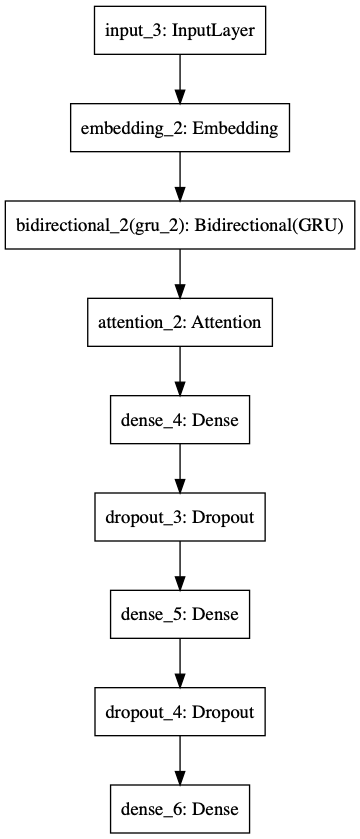

In [46]:
from IPython import display
display.Image('han.png')

In [24]:
train_data = pd.read_csv('../kaggle/tc/train.csv')
import re
train_data['comment_text'] = train_data['comment_text'].apply(lambda x: re.sub('[0-9]','',x))
train_data['comment_text'] = train_data['comment_text'].apply(lambda x: x.replace(',',' , '))
train_data['comment_text'] = train_data['comment_text'].apply(lambda x: x.replace('.',' . '))
train_data['comment_text'] = train_data['comment_text'].apply(lambda x: x.replace(':',' : '))
train_data['comment_text'] = train_data['comment_text'].apply(lambda x: x.replace('!',' ! '))

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
train_data = train_data[['comment_text','toxic']]

In [27]:
train_comment, test_comment, trainy, testy = train_test_split(train_data['comment_text'].tolist(), train_data['toxic'].tolist(), test_size=0.2)

In [28]:
train = pad_sequences(tokenizer.texts_to_sequences(train_comment), 200)
test = pad_sequences(tokenizer.texts_to_sequences(test_comment), 200)

In [29]:
# train, test, trainy, testy = train_test_split(seqeuence_data, train_data['toxic'].tolist(), test_size=0.2)

In [30]:
print ("Total dataset rows: {}".format(len(train_data)))
print ("The train size is {} and the test size is {}".format(len(train), len(test)))

Total dataset rows: 159571
The train size is 127656 and the test size is 31915


In [31]:
print ("The data size is {} MB".format((train.nbytes/(1024*1024)+test.nbytes/(1024*1024))))

The data size is 121.74301147460938 MB


In [496]:
model.predict(np.array(pad_sequences(tokenizer.texts_to_sequences(["i like you","aaa","i hate you"]),200)),batch_size=1)

array([[0.30005792],
       [0.0229266 ],
       [0.99661523]], dtype=float32)

In [497]:
model.predict(np.array(pad_sequences(tokenizer.texts_to_sequences(["i like you","aaa","i hate you"]),200)),batch_size=1)

array([[0.30005792],
       [0.0229266 ],
       [0.99661523]], dtype=float32)

In [36]:
model.predict(np.array(pad_sequences(tokenizer.texts_to_sequences(["i like you"]),200)))

array([[0.54877365]], dtype=float32)

In [47]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(x=train, y=trainy, validation_data=(test,testy), epochs=10, batch_size=1024)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 728s 6ms/step - loss: 0.1524 - acc: 0.9461 - val_loss: 0.0981 - val_acc: 0.9620
Epoch 2/10
127656/127656 [==============================] - 725s 6ms/step - loss: 0.0962 - acc: 0.9641 - val_loss: 0.0937 - val_acc: 0.9640
Epoch 3/10
127656/127656 [==============================] - 714s 6ms/step - loss: 0.0884 - acc: 0.9666 - val_loss: 0.0956 - val_acc: 0.9633
Epoch 4/10
127656/127656 [==============================] - 703s 6ms/step - loss: 0.0835 - acc: 0.9682 - val_loss: 0.0872 - val_acc: 0.9657
Epoch 5/10
127656/127656 [==============================] - 713s 6ms/step - loss: 0.0793 - acc: 0.9704 - val_loss: 0.0889 - val_acc: 0.9642
Epoch 6/10
127656/127656 [==============================] - 712s 6ms/step - loss: 0.0728 - acc: 0.9722 - val_loss: 0.0920 - val_acc: 0.9657
Epoch 7/10
127656/127656 [==============================] - 712s 6ms/step - loss: 0.0669 - acc: 0.9746 - val_

In [48]:
def prepare_to_compute_attention(model):
    hit_model = Model(model.input, model.layers[2].output)
    return hit_model, model.layers[3]

In [49]:
hit_model, trained_attn = prepare_to_compute_attention(model)

In [50]:
hit_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 300)          191911200 
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          329472    
Total params: 192,240,672
Trainable params: 329,472
Non-trainable params: 191,911,200
_________________________________________________________________


In [364]:
def compute_attention(hit_model, trained_attn, text,maxlen=200, model=None, top_n_words=None):
    unpadded_seq = tokenizer.texts_to_sequences([text])
    text_seq = pad_sequences(unpadded_seq, maxlen)

    hit = hit_model.predict(text_seq)
    uit = np.tanh(np.dot(hit,trained_attn.get_weights()[0]) + trained_attn.get_weights()[1])

    alpha_it_num = np.exp(np.dot( uit,trained_attn.get_weights()[2]))

    
    alpha_it = np.squeeze(alpha_it_num/np.sum(alpha_it_num), axis=0)
    
    rank = np.argsort(alpha_it)[::-1]
    if top_n_words and top_n_words > -1:
        rank = rank[:top_n_words]
    elif top_n_words is None:
        rank = rank[:len(unpadded_seq[0])]

    words_index = [text_seq[0][i] for i in rank]
    ranked_words = [tokenizer.index_word[i] if i > 0 else "PAD" for i in words_index]
    ranked_scores = [alpha_it[i] for i in rank]
    word_score = zip(ranked_words, ranked_scores)
    print ("Input sentence is: {}".format(text))
    print ("-"*43+"Sentence Scores"+"-"*43)
    for word, score in word_score:
        print ("{}  -> Score: {}".format(word, score))
    print ("-"*100)
    
    if model:
        return model.predict(text_seq)

In [504]:
train_data[train_data['toxic']==1]['comment_text'].tolist()[1]

'Hey .  .  .  what is it .  . \n@ | talk  . \nWhat is it .  .  .  an exclusive group of some WP TALIBANS .  .  . who are good at destroying ,  self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings .  .  . '

In [506]:
pred = compute_attention(hit_model, trained_attn, train_data[train_data['toxic']==1]['comment_text'].tolist()[1], model=model)
print ("Toxicity Confidence is {}. The sentence is {}toxic".format(pred[0][0], "not " if pred < 0.5 else ""))

Input sentence is: Hey .  .  .  what is it .  . 
@ | talk  . 
What is it .  .  .  an exclusive group of some WP TALIBANS .  .  . who are good at destroying ,  self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings .  .  . 
-------------------------------------------Sentence Scores-------------------------------------------
talibans  -> Score: 0.7511407732963562
at  -> Score: 0.013073247857391834
nonsensical  -> Score: 0.011769592761993408
talk  -> Score: 0.0043888576328754425
at  -> Score: 0.0037656757049262524
some  -> Score: 0.0036290381103754044
of  -> Score: 0.003239171579480171
contribution  -> Score: 0.0029533621855080128
wp  -> Score: 0.002878199564293027
.  -> Score: 0.0020450653973966837
it  -> Score: 0.0020295819267630577
what  -> Score: 0.002007527742534876
self  -> Score: 0.0017975852824747562
.  -> Score: 0.0017473032930865884


In [65]:
prediction = model.predict(test)

In [66]:
prediction[prediction<0.5] = 0
prediction[prediction>=0.5] = 1

In [67]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report( testy,prediction))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     28907
           1       0.76      0.82      0.79      3008

   micro avg       0.96      0.96      0.96     31915
   macro avg       0.87      0.90      0.88     31915
weighted avg       0.96      0.96      0.96     31915



In [68]:
correct_preds = np.array(test_comment)

In [69]:
correct_preds = correct_preds[prediction.reshape(prediction.shape[0],)==1]

In [507]:
compute_attention(hit_model, trained_attn, correct_preds[8], model=model)

Input sentence is: You are a coward and a fool . 
-------------------------------------------Sentence Scores-------------------------------------------
coward  -> Score: 0.6398849487304688
fool  -> Score: 0.12289978563785553
and  -> Score: 0.07871033996343613
a  -> Score: 0.06948813796043396
a  -> Score: 0.03356339782476425
are  -> Score: 0.004199539311230183
.  -> Score: 0.0014046343276277184
you  -> Score: 0.0005218124715611339
----------------------------------------------------------------------------------------------------


array([[0.9994759]], dtype=float32)

In [80]:
correct_preds[5]

'Hello ,  I think you are a fuckwad .  Eat shit and die?'

In [477]:
test[28].reshape(1,200).shape

(1, 200)

In [500]:
predict_comment = model.predict(test)
predict_comment[predict_comment>=0.5] = 1
np.sum(predict_comment)

1438.5312

In [501]:
predict_comment[predict_comment<0.5] = 0
np.sum(predict_comment)

1349.0

# Sentence Tokenize and Training with Hierarchical Attention Network Architecture

In [83]:
from nltk import word_tokenize, sent_tokenize

In [99]:
len([word_tokenize(sent) for sent in sent_tokenize(correct_preds[9])])

3

In [184]:
def get_han_model(n_classes=1, wordlen=40, sent_len=5):
#     inputs = [Input(shape(wordlen,)) for i in range(sent_len)]
#     embd_layer = Embedding(input_dim=embedding.shape[0], output_dim=embedding.shape[1], input_length=maxlen, weights=[embedding], trainable=False, mask_zero=True)
#     embds = [embd_layer(inp) for inp in inputs]
#     gru_layer = Bidirectional(GRU(128, return_sequences=True))
    input = Input(shape=(sent_len,wordlen))
    emb_layer = TimeDistributed(Embedding(input_dim=embedding.shape[0], output_dim=embedding.shape[1], input_length=wordlen, weights=[embedding], trainable=False, mask_zero=True))(input)
    hit = TimeDistributed( Bidirectional(GRU(128, return_sequences=True)))(emb_layer)
    attn_vecs = TimeDistributed(Attention(128))(hit)
    
    sent_hit = Bidirectional(GRU(128, return_sequences=True))(attn_vecs)
    sent_attn_vecs = Attention(128)(sent_hit)
    output = Dense(128,activation='relu')(sent_attn_vecs)
    output = Dropout(0.2)(output)
    output = Dense(32,activation='relu')(output)
    output = Dropout(0.2)(output)
    output = Dense(n_classes, activation='sigmoid')(output)
    model = Model(input, output)
    return model

In [191]:
han_model = get_han_model(1,40,5)

shape of hit is (?, 40, 256)
shape of kernel_w is (256, 128)
shape of kernel_wb is (128,)
shape of kernel_uw is (128,)
shape of expanded kernel is Tensor("time_distributed_17/ExpandDims:0", shape=(1, 256, 128), dtype=float32)
UIT shape is (?, 40, 128)
shape of uit is (?, 40, 128)
Shape of alpha_num is (?, 40)
Shape of alpha_num after mask multiplication (?, 40)
shape of alpha_it is (?, 40)
shape of si is (?, 40, 256)
shape of si after sum is (?, 256)
shape of hit is (?, ?, 256)
shape of kernel_w is (256, 128)
shape of kernel_wb is (128,)
shape of kernel_uw is (128,)
shape of expanded kernel is Tensor("attention_12/ExpandDims:0", shape=(1, 256, 128), dtype=float32)
UIT shape is (?, 5, 128)
shape of uit is (?, 5, 128)
Shape of alpha_num is (?, 5)
Shape of alpha_num after mask multiplication (?, 5)
shape of alpha_it is (?, 5)
shape of si is (?, 5, 256)
shape of si after sum is (?, 256)


In [183]:
keras.utils.plot_model(han_model, 'full_han.png')

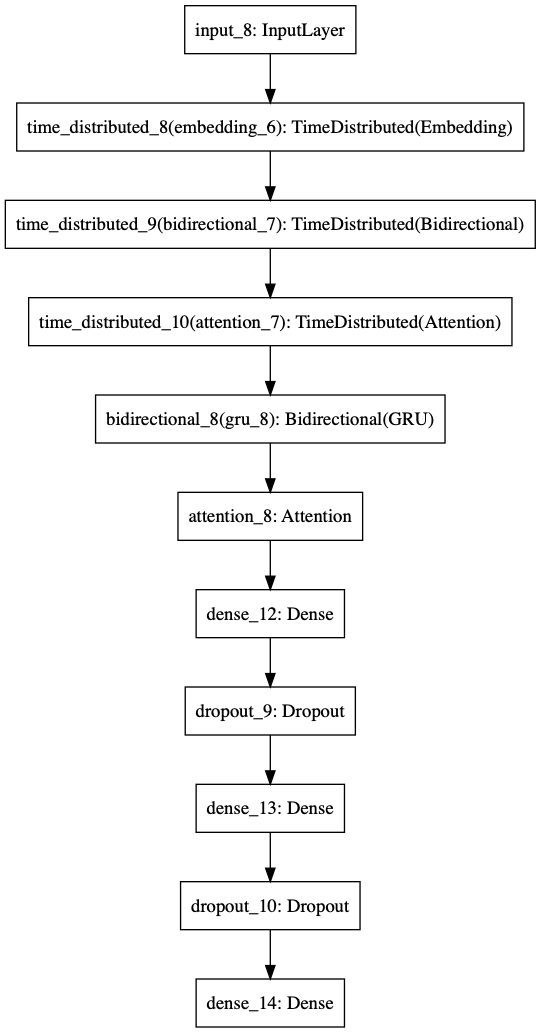

In [126]:
display.Image('full_han.png')

In [127]:
han_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 5, 40)             0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 5, 40, 300)        191911200 
_________________________________________________________________
time_distributed_9 (TimeDist (None, 5, 40, 256)        329472    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 5, 256)            33024     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 5, 256)            295680    
_________________________________________________________________
attention_8 (Attention)      (None, 256)               33024     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
__________

In [189]:
def prepare_input(sentences, wordlen=40, sentlen=5):
    output = None
    for sentence in sentences:
        sents = sent_tokenize(sentence)
        sents = sents[:sentlen]
        while len(sents) < sentlen:
            sents.append(" ")
        if output is None:
            output = np.expand_dims(pad_sequences(tokenizer.texts_to_sequences(sents),wordlen),0)
        else:
            output = np.append(output,np.expand_dims(pad_sequences(tokenizer.texts_to_sequences(sents),wordlen),0), axis=0)
#     print (output.shape)
    return output

In [194]:
han_model.predict(prepare_input([correct_preds[10]]))

array([[0.99993384]], dtype=float32)

In [134]:
test_word_vec_model = Model(han_model.input, han_model.layers[3].output)

In [138]:
test_word_vec_model.predict(prepare_input(correct_preds[3]).reshape(1,5,40))

array([[[-0.01293012,  0.01512896, -0.00848631, ..., -0.00506174,
         -0.00130085,  0.00469162],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)

In [176]:
def generate_data(datax,datay,batch_size):
    while True:
        indexes = np.random.choice(range(len(datax)), size=batch_size)
        X = prepare_input(np.array(datax)[indexes])
        Y = np.array(datay)[indexes]
        yield X, Y.tolist()

In [193]:
han_model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['acc'])
han_model.fit_generator(generate_data(train_comment, trainy,256),  steps_per_epoch=len(train_comment)/256, epochs=10)

Epoch 1/10
499/498 [==============================] - 3706s 7s/step - loss: 0.1256 - acc: 0.9580
Epoch 2/10
499/498 [==============================] - 3649s 7s/step - loss: 0.0694 - acc: 0.9765A: 2:23 - loss: 0.0701 - acc: 0.976 - ETA: 2:16 - loss: 0.0700 - acc - ETA: 1:17 - loss: 0.
Epoch 3/10
499/498 [==============================] - 3658s 7s/step - loss: 0.0478 - acc: 0.9840
Epoch 4/10
499/498 [==============================] - 3646s 7s/step - loss: 0.0338 - acc: 0.9895
Epoch 5/10
499/498 [==============================] - 3663s 7s/step - loss: 0.0232 - acc: 0.9930A: 56s - loss: 0.0234
Epoch 6/10
499/498 [==============================] - 3662s 7s/step - loss: 0.0185 - acc: 0.9944A: 11
Epoch 7/10
499/498 [==============================] - 3739s 7s/step - loss: 0.0145 - acc: 0.9956
Epoch 8/10
499/498 [==============================] - 3633s 7s/step - loss: 0.0113 - acc: 0.9968
Epoch 9/10


KeyboardInterrupt: 

In [196]:
han_predictions = han_model.predict(prepare_input(test_comment),batch_size=512)

In [197]:
han_predictions[han_predictions>=0.5] = 1.0
han_predictions[han_predictions<0.5] = 0.

In [198]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report( testy,han_predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28907
           1       0.83      0.64      0.72      3008

   micro avg       0.95      0.95      0.95     31915
   macro avg       0.89      0.81      0.85     31915
weighted avg       0.95      0.95      0.95     31915



In [203]:
def prepare_han_model(han_model):
    sent_hit_model = Model(han_model.input, han_model.layers[4].output)
    return sent_hit_model, han_model.layers[5]

In [474]:
def compute_attention_han(sent_hit_model, trained_attn, text,wordlen=40, sentlen=5, model=None):

    text_seq = prepare_input([text], wordlen, sentlen)
    sentences = sent_tokenize(text)
    while len(sentences) < sentlen:
        sentences.append("PADDED SENTENCES")
    
    hit = sent_hit_model.predict(text_seq)
    uit = np.tanh(np.dot(hit,trained_attn.get_weights()[0]) + trained_attn.get_weights()[1])
    
    alpha_it_num = np.squeeze(np.exp(np.dot( uit,trained_attn.get_weights()[2])),0)
    alpha_it = alpha_it_num/np.sum(alpha_it_num)
    
    rank = np.argsort(alpha_it)[::-1]
    print ("Input Sentence:   {}".format(text))
    ranked_sentences = [(sentences[i],alpha_it[i]) for i in rank]
    print ("-"*43+"Sentence Scores"+"-"*43)
    for rsent in ranked_sentences:
        print ("{}  -> Score: {}".format(rsent[0],rsent[1]))
    print ("-"*100)

    if model:
        return model.predict(text_seq)

In [475]:
sent_hit_model, sent_attn = prepare_han_model(han_model)

In [476]:
pred = compute_attention_han(sent_hit_model, sent_attn, correct_preds[0], 40,5,han_model)
print ("Toxicity Confidence is {}. The sentence is {}toxic".format(pred[0][0], "not " if pred < 0.5 else ""))

Input Sentence:   Why? 

Why is this page so zealously guarded .  .  .  by so many idiots? Never seen anything like it . ~
-------------------------------------------Sentence Scores-------------------------------------------
by so many idiots?  -> Score: 0.5817959308624268
.  -> Score: 0.16015098989009857
Why is this page so zealously guarded .  -> Score: 0.12911401689052582
.  -> Score: 0.09135065972805023
Why?  -> Score: 0.03758838400244713
----------------------------------------------------------------------------------------------------
Toxicity Confidence is 0.8409721255302429. The sentence is toxic


In [477]:
def prepare_word_attn_from_han_model(han_model):
    han_word_model = Model(han_model.input, han_model.layers[2].output)
    word_attn = han_model.layers[3]
    return han_word_model, word_attn

In [478]:
def compute_attention_han_wordlevel(han_word_model, word_attn, sent_hit_model, sent_attn, text,wordlen=40, sentlen=5, model=None):
    sentences = sent_tokenize(text)
    while len(sentences) < sentlen:
        sentences.append("PADDED SENTENCES")

    text_seq = prepare_input([text], wordlen, sentlen)
    word_hit = han_word_model.predict(text_seq)
    word_hit = np.squeeze(word_hit, axis=0)
    uit = np.tanh(np.dot(word_hit,word_attn.get_weights()[0]) + word_attn.get_weights()[1])

    alpha_it_num = np.exp(np.dot( uit,word_attn.get_weights()[2]))
    alpha_it = alpha_it_num/np.sum(alpha_it_num, axis=1, keepdims=True)

    rank = np.argsort(alpha_it, axis=1)[::-1]
    
    words = []
    for row in range(rank.shape[0]):
        words.append([tokenizer.index_word[text_seq[0][row][i]] if text_seq[0][row][i] > 0 else "*" for i in rank[row]])
    
    compute_attention_han(sent_hit_model, sent_attn, text, wordlen,sentlen,model)
    
    print ("-"*43+"Word Scores"+"-"*43)
    for sent in words:
        print (" > ".join(sent))
    print ("-"*100)
    if model:
        return model.predict(text_seq)
    

In [479]:
han_word_model, word_attn = prepare_word_attn_from_han_model(han_model)

In [486]:
pred = compute_attention_han_wordlevel(han_word_model, word_attn,sent_hit_model, sent_attn, correct_preds[10], 40,5,han_model)
print ("Toxicity Confidence is {}. The sentence is {}toxic".format(pred[0][0], "not " if pred < 0.5 else ""))

Input Sentence:   """I want to be a fuck you . ""
That's a song . 

"
-------------------------------------------Sentence Scores-------------------------------------------
"""I want to be a fuck you . ""  -> Score: 0.8817136287689209
That's a song . 

"  -> Score: 0.03768691048026085
PADDED SENTENCES  -> Score: 0.026866456493735313
PADDED SENTENCES  -> Score: 0.026866456493735313
PADDED SENTENCES  -> Score: 0.026866456493735313
----------------------------------------------------------------------------------------------------
-------------------------------------------Word Scores-------------------------------------------
* > * > * > * > * > * > * > * > * > * > """i > want > to > be > a > fuck > you > * > * > * > * > * > * > * > * > * > * > * > * > * > * > * > * > * > * > * > * > * > . > ""
* > * > * > * > * > * > * > * > * > * > * > * > * > * > that's > a > song > * > * > * > * > * > * > * > * > * > * > * > * > * > * > * > * > * > * > * > * > * > . > "
* > * > * > * > * > * > * > * >